# Foundations of Logistic Regression

In [22]:
import os

# Change the current working directory
os.chdir('/Users/Sari/Documents/Code/Semester 4 workbooks')

In [23]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import seaborn as sns

## Exercise I: Inference and Prediction for the Homogeneous-Probability Bernoulli Model

#### a) Simulate a sample of n = 100 Bernoulli distributed outcomes, with the following probability parameter:

In [24]:
p = 0.3
sample_size = 100
samples = bernoulli.rvs(p, size=sample_size)

#### do not look at the value of this parameters - we are going to pretend you're generating a fresh sample, and your goal is to estimate $\pi$. Imagine this $\pi$ represents the probability of any one of you saying they will vote for a right-of-centre party in the next Dutch election, and $n = 100$ suggests there are 100 of you to whom this question is being asked.

#### b) Plot the empirical distribution (histogram of simulations) for this set of Bernoulli outcomes

(array([75.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 25.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

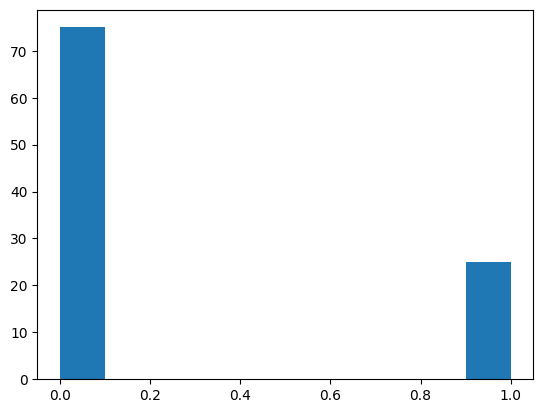

In [25]:
plt.hist(samples)

#### c) Estimate the value of $\pi$ which is most likely to have generated this set of observations

In [26]:
# Averaging the outcomes will give me the most likelihood estimate.
mle = np.average(samples)
print(F"p is estimated at {mle}")

p is estimated at 0.25


#### d) There is uncertainty around this estimate. In theory, why might such uncertainty arise ? 

#### Answer: The estimate is based on a sample of stochastic outcomes rather than deterministic outcomes. By random chance, we could have ended up with a different distribution than the "most likely one" given the true probability parameter. Example: a hundred coin tosses can give us 60 tails and 40 heads just by chance, even if the true probability of a tail is 0.5. 

#### e) Represent the uncertainty around this estimate using the empricial posterior distribution evaluated at the MLE. Simulate 1000 values of $\pi$ under this distribution. Plot a histogram of the empirical posterior. 

#### Hint: there are two candidate posterior distributions you can use here -- any one will do...

In [27]:
# With 100 samples and an MLE of 0.34, I'm assuming that a normal approximation
# will work here.

ep_simulation_n = 1000
ep_variance = (mle * (1 - mle)) / sample_size

empirical_posterior = norm.rvs(loc=mle, scale=ep_variance, size=ep_simulation_n)

<Axes: ylabel='Count'>

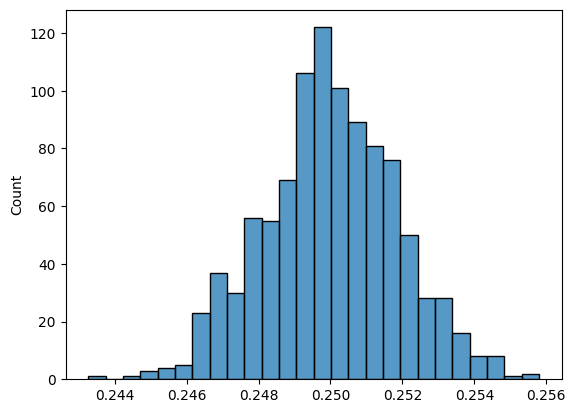

In [28]:
sns.histplot(empirical_posterior)

#### f) For each simulated value of $\pi$, generate a new sample of observations `y`. Plot the histogram of these newly generated samples. If you were to observe a new individual from this population, would you classify them as a right-of-centre voter ? and why ?  

<Axes: ylabel='Count'>

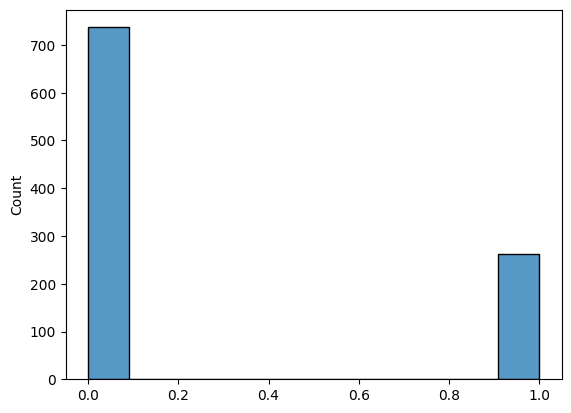

In [29]:
# Here we use the posterior predictive distribution of y 
# to generate new samples for a hypothetical unobserved student

# For each simulated pi, generate a sample from a bernoulli distribution with
# the simulated pi as parameter
post_pred_sims = [bernoulli.rvs(pi_sim) for pi_sim in empirical_posterior]

sns.histplot(post_pred_sims)

The most probable outcome of our simulation is y = 0, which in this case would mean that a given individual y is more likely to not vote right of center. I would thus classify a new individual from this population as "not a right-of-center voter".

## Exercise II: Logistic Regression, Simulation-Based Inference & Prediction

#### a)  For this, I will load my tree dataset again. The dataset is a collection of trees from Amsterdam with associated values for each tree.

The goal of this model is to predict whether a tree is "tall" or not. A tall tree is a tree that is taller than 10 meters, according to my very scientific judgement.

In [30]:
# Load tree data
df = pd.read_csv('data/clean_tree_data.csv')
# the dataset is much bigger than we need, sampling from it
data_n = 2000
df = df.sample(data_n, random_state=31415)
df.drop(['Unnamed: 0', 'tree_height_random'], axis=1, inplace=True)

# Check dataset
display(df.head())

,growth_ground,diameter,tree_height_fixed,tree_admin,tree_municipality,age,species,species_group,tree_treatment,Naam_buurt,Naam_wijk,parked_cars_in_neighbourhood
16058,Gazon,0.40,21.0,Recreatieschap Noord-Holland,Gemeente Amsterdam,59.0,Quercus robur cv.,Quercus,Boom niet vrij uitgroeiend,Osdorper Binnenpolder,Geuzenveld,856
8176,Vaste planten,0.25,16.5,R&E_VOR_Bomen,Gemeente Amsterdam,32.0,Ulmus minor 'Sarniensis',Ulmus,Boom niet vrij uitgroeiend,Bellamybuurt-Zuid,Bellamybuurt,318
4343,Gazon,0.25,13.5,R&E_VOR_Bomen,Gemeente Amsterdam,41.0,Tilia europaea,Tilia,Boom niet vrij uitgroeiend,Amstel III deel A/B-Noord,Amstel III/Bullewijk,16
16059,Gazon,0.40,21.0,Recreatieschap Noord-Holland,Gemeente Amsterdam,59.0,Fraxinus excelsior cv.,Fraxinus,Boom niet vrij uitgroeiend,Osdorper Binnenpolder,Geuzenveld,856
9412,Bloemrijk gras,0.75,21.0,R&E_VOR_Bomen,Gemeente Amsterdam,54.0,Quercus palustris,Quercus,Boom niet vrij uitgroeiend,Drieburg,Betondorp,397


#### b) Nothing needed at this step

#### c) Define the outcome of interest as 1 if the tree is of the genus is "Platanus" and 0 otherwise.

In [31]:
df['is_tall'] = pd.Series(df['tree_height_fixed'] > 10).astype(int)
df['is_tall'].value_counts()

is_tall
1    1363
0     637
Name: count, dtype: int64

In [32]:
Y = df['is_tall']
Y

16058    1
8176     1
4343     1
16059    1
9412     1
        ..
23032    0
23176    1
9789     1
23427    1
13461    1
Name: is_tall, Length: 2000, dtype: int64

In [33]:
# streamlining "tree treatment" otherwise the model overflows
print(df['tree_treatment'].unique())
# We'll just have "growing_freely" as a variable
df['growing_freely'] = pd.Series(
    df['tree_treatment'] == 'Boom vrij uitgroeiend'
).astype(int)

print(df['growing_freely'].value_counts())

['Boom niet vrij uitgroeiend' 'Knotboom' 'Boom vrij uitgroeiend' 'Stobbe'
 'Vormboom' 'Gekandelaberde boom']
growing_freely
0    1838
1     162
Name: count, dtype: int64


#### d) My design matrix for predicting tallness will include diameter, species, age, and whether the tree is growing freely.

#### Note: Remember the `dummy trap`...if you have a categorical variable with `m` possible values, you can only have `m-1` such variables be dummies in your model, due to perfect multi-collinearity...

In [34]:
# Create design matrix 
X = pd.DataFrame({
    'diameter': df['diameter'],
    'age': df['age'],
    'growing_freely': df['growing_freely'],
})

categorical_vars = ['species_group']

for category in categorical_vars:
    dummies = pd.get_dummies(df[category], prefix=category, drop_first=True)
    dummies = dummies.astype(float)
    X = pd.concat([X, dummies], axis=1)

# Display the first few rows of the DataFrame
display(X.head())

,diameter,age,growing_freely,species_group_Aesculus,species_group_Ailanthus,species_group_Alnus,species_group_Amelanchier,species_group_Betula,species_group_Carpinus,species_group_Castanea,...,species_group_Quercus,species_group_Robinia,species_group_Salix,species_group_Sequoiadendron,species_group_Sorbus,species_group_Styphnolobium,species_group_Taxodium,species_group_Taxus,species_group_Tilia,species_group_Ulmus
16058,0.40,59.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8176,0.25,32.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4343,0.25,41.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16059,0.40,59.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9412,0.75,54.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### e) Explore the correlation matrix between the covariates and the outcome. Which variables are most linearly related ? Does the direction of the correlation make sense ? Which covariates are most related to the outcome ? 

#### Hint: remember to drop missing values... for both X and Y...

In [35]:
YX = pd.concat([Y, X], axis=1)
YX = YX.dropna()

# Examine the correlation between covariates and outcome (outcome is the first column)
# Can you identify some `perfect multicollinearity' that could hinder the estimation ? 
np.corrcoef(YX.T)

array([[ 1.        ,  0.44662125,  0.38662845, ..., -0.0414613 ,
         0.10132444,  0.16478053],
       [ 0.44662125,  1.        ,  0.62428697, ..., -0.01967354,
         0.01161665,  0.14401231],
       [ 0.38662845,  0.62428697,  1.        , ...,  0.03336102,
         0.17315451,  0.02411843],
       ...,
       [-0.0414613 , -0.01967354,  0.03336102, ...,  1.        ,
        -0.01772299, -0.01776079],
       [ 0.10132444,  0.01161665,  0.17315451, ..., -0.01772299,
         1.        , -0.15707235],
       [ 0.16478053,  0.14401231,  0.02411843, ..., -0.01776079,
        -0.15707235,  1.        ]])

#### f) Fit the logistic regression model using statsmodels. Make sure the estimation procedure has converged.
#### If not, examine the errors and figure out why it's not. Remember to drop the NAs.

In [36]:
X_with_intercept = sm.add_constant(X)
X_with_intercept.dropna(inplace=True)
model = sm.Logit(Y, X_with_intercept).fit(maxiter=1000, method='bfgs')

Optimization terminated successfully.
         Current function value: 0.342939
         Iterations: 320
         Function evaluations: 323
         Gradient evaluations: 323


#### g) Get summary of regression output.

In [37]:
# Get summary results
summary = model.summary()
summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_tall   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1953
Method:                           MLE   Df Model:                           46
Date:                Mon, 01 Apr 2024   Pseudo R-squ.:                  0.4519
Time:                        13:13:25   Log-Likelihood:                -685.88
converged:                       True   LL-Null:                       -1251.5
Covariance Type:            nonrobust   LLR p-value:                7.747e-207
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -2.7307      0.273     -9.990      0.000      -3.266      -2.195
diameter                        11.0388      0.977     11.294      0.000       9.123      12.954
age                              0.0249      0.006      3.964      0.000       0.013       0.037
growing_freely                  -0.1796      0.269     -0.667      0.505      -0.707       0.348
species_group_Aesculus          -1.7699      0.607     -2.917      0.004      -2.959      -0.581
species_group_Ailanthus          0.4891      0.620      0.789      0.430      -0.726       1.704
species_group_Alnus              1.9528      0.451      4.329      0.000       1.069       2.837
species_group_Amelanchier      -16.3870   1911.023     -0.009      0.993   -3761.924    3729.150
species_group_Betula            -0.3167      0.318     -0.995      0.320      -0.941       0.307
species_group_Carpinus          -0.8162      0.351     -2.325      0.020      -1.504      -0.128
species_group_Castanea           9.4063    168.978      0.056      0.956    -321.785     340.598
species_group_Catalpa           -1.0807      1.303     -0.830      0.407      -3.634       1.472
species_group_Celtis           -15.2665   1354.047     -0.011      0.991   -2669.151    2638.618
species_group_Cornus           -11.2135    309.187     -0.036      0.971    -617.208     594.781
species_group_Corylus           -0.0045      0.673     -0.007      0.995      -1.324       1.315
species_group_Crataegus         -2.9538      0.544     -5.433      0.000      -4.019      -1.888
species_group_Fagus             -0.1341      0.772     -0.174      0.862      -1.648       1.380
species_group_Fraxinus           0.9257      0.309      2.996      0.003       0.320       1.531
species_group_Ginkgo             0.0923      0.536      0.172      0.863      -0.958       1.143
species_group_Gleditsia         -0.3255      0.533     -0.611      0.541      -1.370       0.719
species_group_Ilex             -21.7668   1.74e+04     -0.001      0.999   -3.41e+04    3.41e+04
species_group_Juglans           -9.0506    143.463     -0.063      0.950    -290.233     272.132
species_group_Juniperus         -8.6482    124.843     -0.069      0.945    -253.335     236.039
species_group_Koelreuteria     -16.3351   1284.297     -0.013      0.990   -2533.510    2500.840
species_group_Liquidambar        0.2123      0.589      0.361      0.718      -0.941       1.366
species_group_Liriodendron      11.7402    412.446      0.028      0.977    -796.640     820.120
species_group_Magnolia         -15.6708   1604.524     -0.010      0.992   -3160.481    3129.139
species_group_Malus            -17.9418   1359.756     -0.013      0.989   -2683.014    2647.130
species_group_Metasequoia       15.0915   1132.577      0.013      0.989   -2204.720    2234.903
species_group_Ostrya            -1.8161      1.590     -1.142      0.253      -4.933       1.301
species_group_Parrotia         -12.8617 

#### h) Simulate 1000 values for for each regression coefficient, from the empirical posterior distribution. Remember this is a Multivariate normal. Use  model.cov_params() to extract the covariance matrix. 

In [38]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

/Users/Sari/Documents/Code/Semester 4 workbooks/venv/lib/python3.12/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


#### i) Calculate summary statistics from these simulations, along with the probability of the coefficient being > 0 . Plot the histograms for each coefficient. Comment on the statistical significance. What should you do if you wish to compare effect sizes across coefficients ?

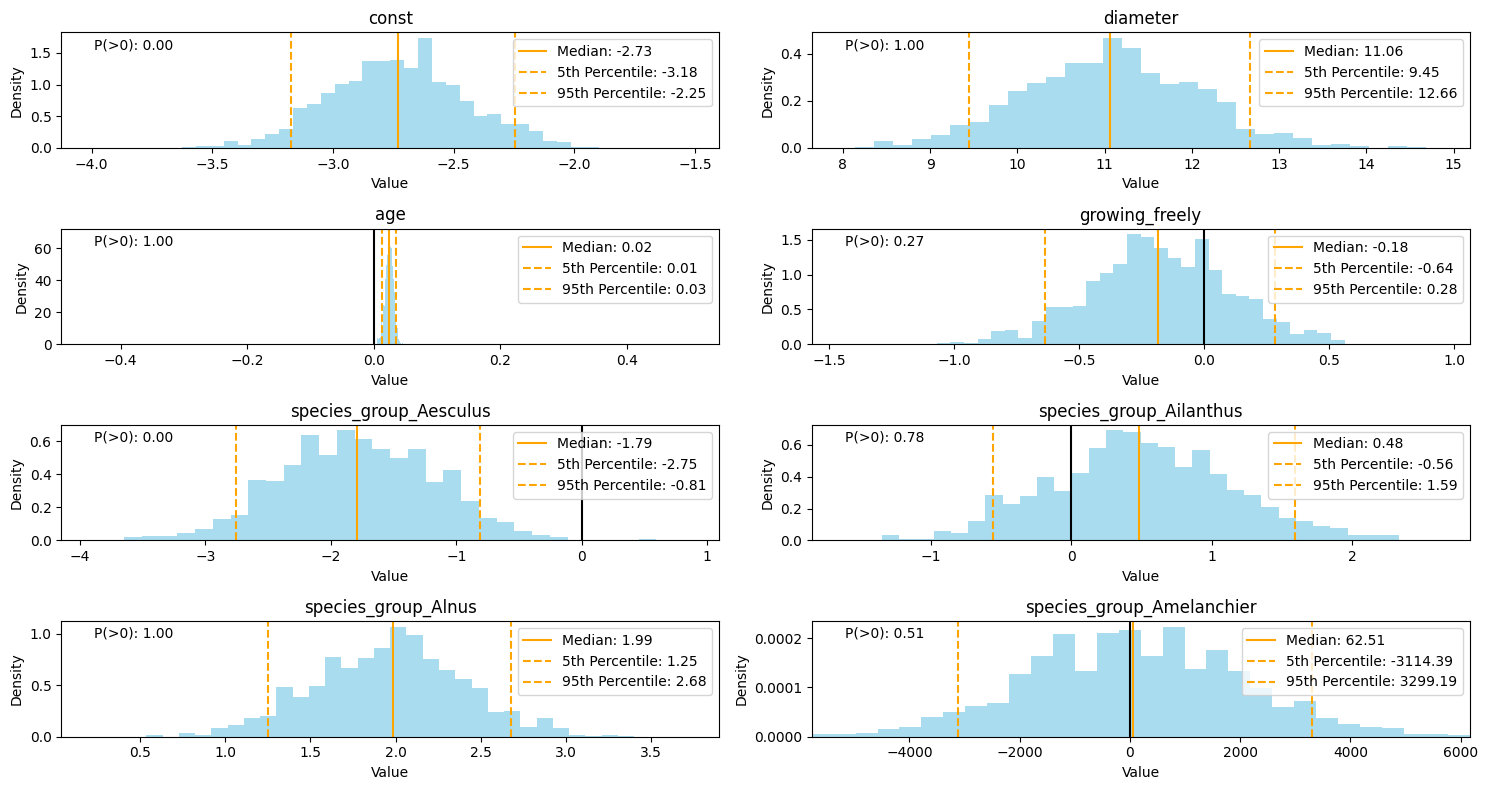

In [44]:
# Calculate statistics for each coefficient
medians = np.median(simulated_betas, axis=0)
lower_quantiles = np.percentile(simulated_betas, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas, 95, axis=0)
prob_positive = np.mean(simulated_betas > 0, axis=0)
# there are too many coeffs to fit them all so let's just look at the first 8
num_coeffs = 8

# Plot histograms of each coefficient
num_rows = (num_coeffs + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(num_coeffs):
    ax = axs[i]
    ax.hist(simulated_betas[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(0, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 0
    ax.text(0.05, 0.95, f'P(>0): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{X_with_intercept.columns[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 0
    ax.set_xlim(left=min(simulated_betas[:, i]) - 0.5, right=max(simulated_betas[:, i]) + 0.5)
    
# Hide empty subplot
if num_coeffs % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

#### i) Now let's practice making predictions from this model that we learned. Below is definded the `average american voter`. For this hypothetical person, make a prediction for the probability of voting republican. Ensure to use simulations to gennerate samples of this probability,  and fully account for uncertainty. 

#### Hint: use the `logistic_sigmoid` function to turn simulations of $\mu$ into $\pi$.

In [40]:
# Calculate the average of the sample for each predictor
average_X = X_with_intercept.mean(axis=0)

# Generate new predicted probabilities for the new observation using the simulated betas
new_predicted_probs = logistic_sigmoid(np.dot(simulated_betas, average_X))

#### l) Now generate values from the posterior predictive distirbution of the outcome Y (So for this hypothetical average voter, simulate 1000 times who they will vote for). Who does the average american voter turn to in 2020

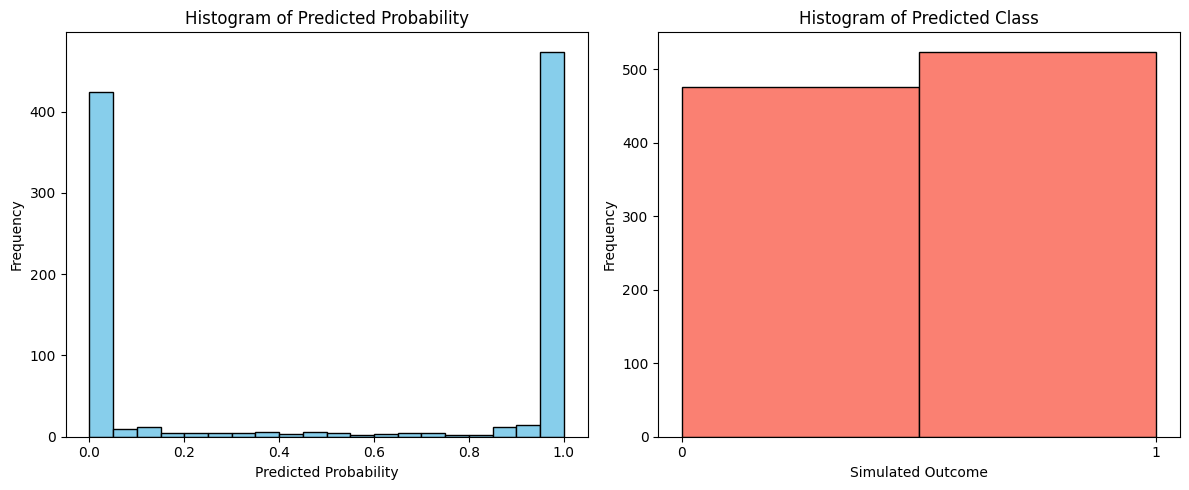

In [41]:
# Simulate outcomes for the new observation based on the new predicted probabilities
new_simulated_outcomes = np.random.binomial(1, new_predicted_probs)

# Plotting both the new predicted probabilities and the simulated outcomes in histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for new predicted probabilities
axes[0].hist(new_predicted_probs, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Predicted Probability')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')

# Plot for simulated outcomes
axes[1].hist(new_simulated_outcomes, bins=2, color='salmon', edgecolor='black')
axes[1].set_title('Histogram of Predicted Class')
axes[1].set_xlabel('Simulated Outcome')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])

plt.tight_layout()
plt.show()

